In [1]:
import numpy as np
import xarray as xr
import netCDF4
import os
import matplotlib.pyplot as plt
import numpy.ma as ma
import pandas as pd
import glob

In [2]:
data_dir = r"/home/raraki/waves/projects/smap-drydown/data"
datarod_dir = r"/home/raraki/waves/projects/smap-drydown/data/datarods"
rangeland_dir = "rangeland_resampled_avg"
shape = (406, 964)
width = shape[1]

# Get template EASE grid

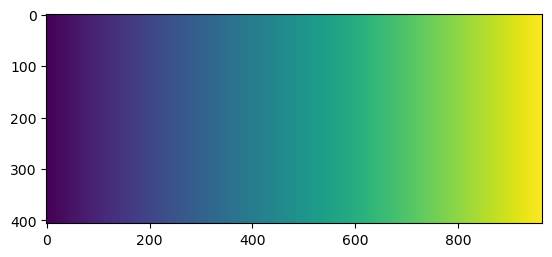

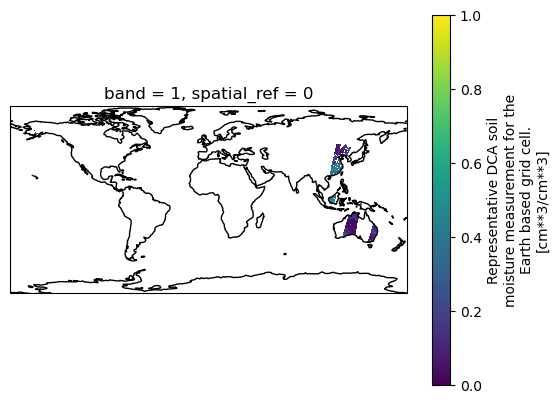

In [3]:
SMAPL3_grid_sample = r"/home/waves/projects/smap-drydown/data/SPL3SMP/SMAP_L3_SM_P_20150331_R18290_001.h5"
ncf = netCDF4.Dataset(SMAPL3_grid_sample, diskless=True, persist=False)
nch_am = ncf.groups.get('Soil_Moisture_Retrieval_Data_AM')
nch_pm = ncf.groups.get('Soil_Moisture_Retrieval_Data_PM')

# %%
# Return as regular numpy array rather than masked array
_latitude = ma.getdata(nch_am.variables['latitude'][:].filled(fill_value=np.nan), subok=True)
_longitude = ma.getdata(nch_am.variables['longitude'][:].filled(fill_value=np.nan), subok=True)
_EASE_column_index = ma.getdata(nch_am.variables['EASE_column_index'][:].astype(int).filled(fill_value=-1), subok=True)
_EASE_row_index = ma.getdata(nch_am.variables['EASE_row_index'][:].astype(int).filled(fill_value=-1), subok=True)

# %%
# Coordinates with no data are skipped --- fill them
latitude = np.nanmax(_latitude, axis=1)
EASE_row_index = np.nanmax(_EASE_row_index, axis=1)
longitude = np.nanmax(_longitude, axis=0)
EASE_column_index = np.nanmax(_EASE_column_index, axis=0)

EASE_row_index_expanded = np.tile(EASE_row_index, (len(EASE_column_index), 1)).T 
EASE_column_index_expanded = np.tile(EASE_column_index, (len(EASE_row_index), 1))
plt.imshow(EASE_column_index_expanded)

_ds_SMAPL3 = xr.open_dataset(SMAPL3_grid_sample, engine='rasterio', group='Soil_Moisture_Retrieval_Data_AM', variable=['soil_moisture'])
ds_SMAPL3_coord_template = _ds_SMAPL3.assign_coords({'x':longitude, 'y':latitude}).rio.write_crs("epsg:4326")

import cartopy.crs as ccrs
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': projection})
# Plot the new data
ds_SMAPL3_coord_template.sel(band=1).Soil_Moisture_Retrieval_Data_AM_soil_moisture.plot(ax=ax, transform=projection, vmin=0, vmax=1)
ax.coastlines()
plt.show()

# Import resampled data

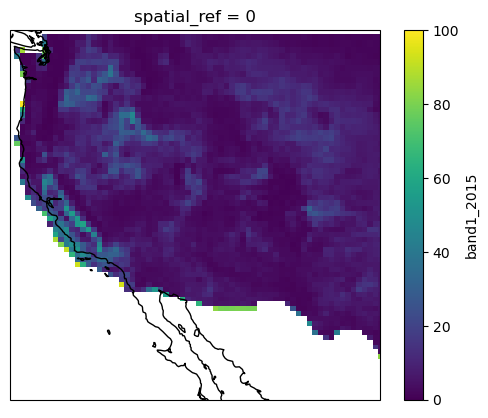

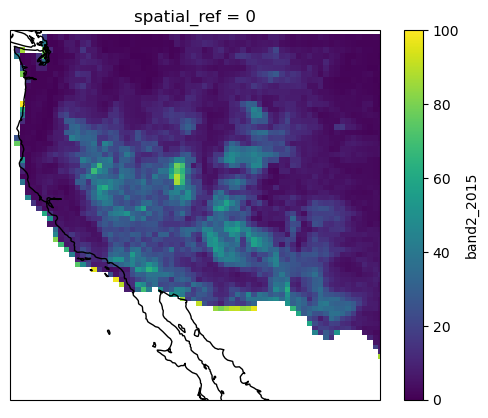

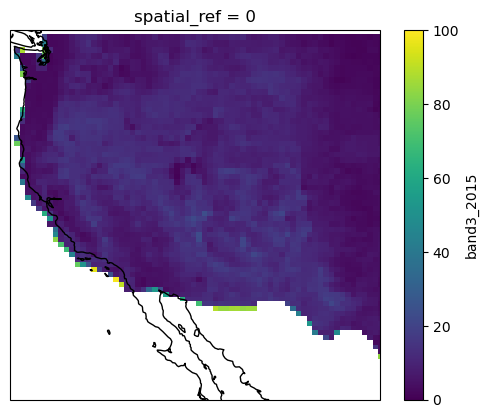

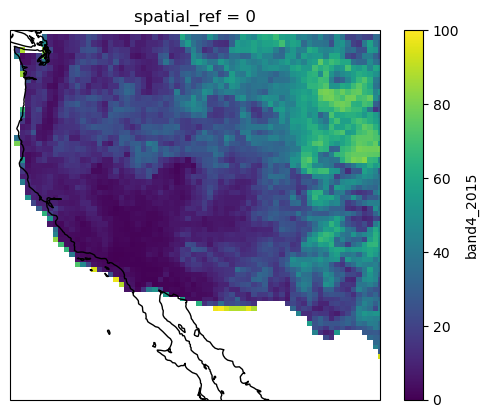

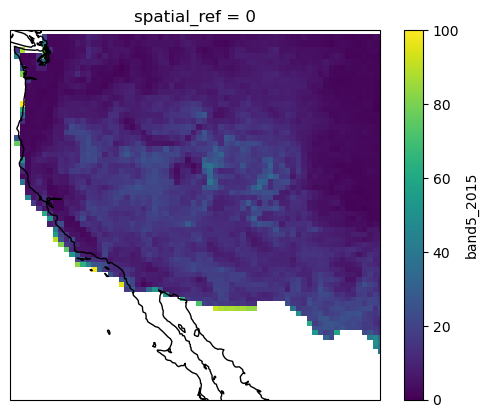

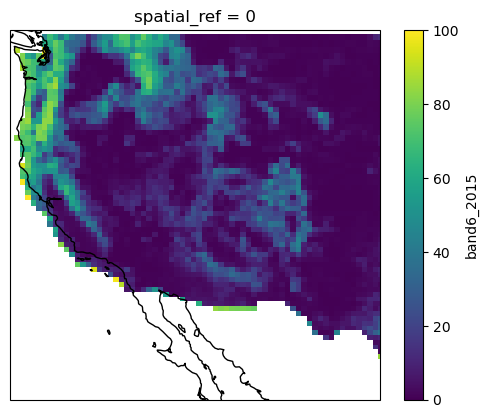

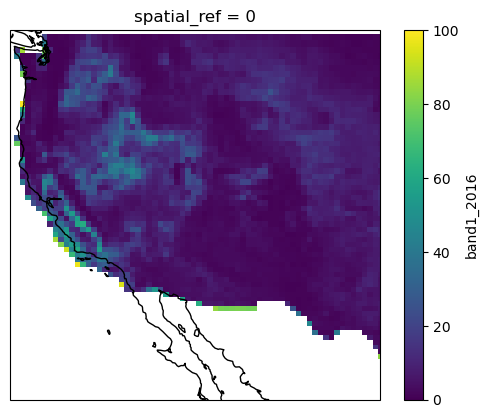

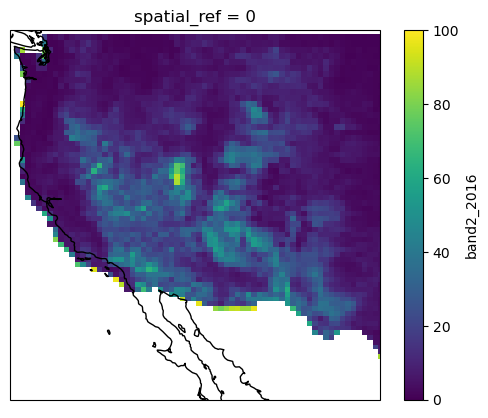

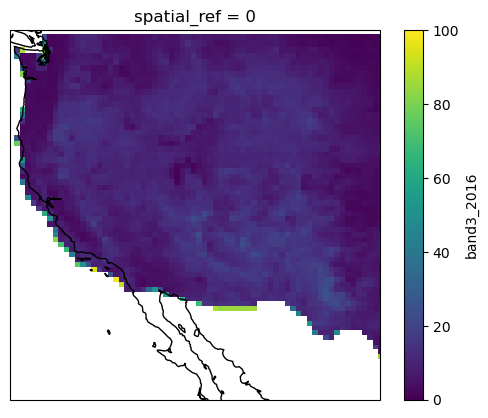

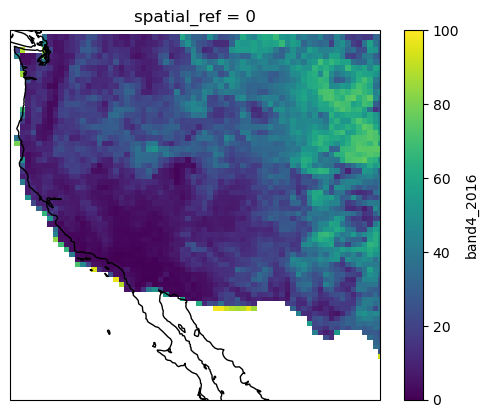

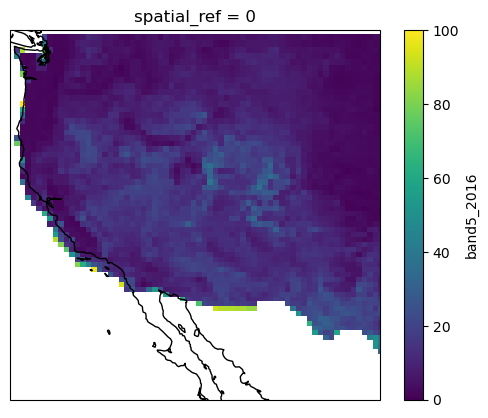

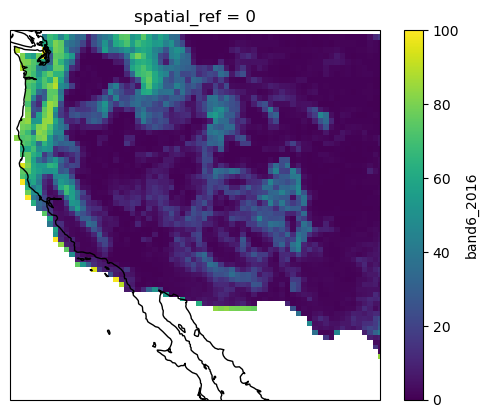

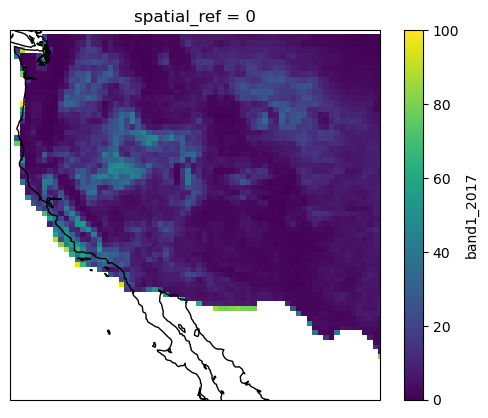

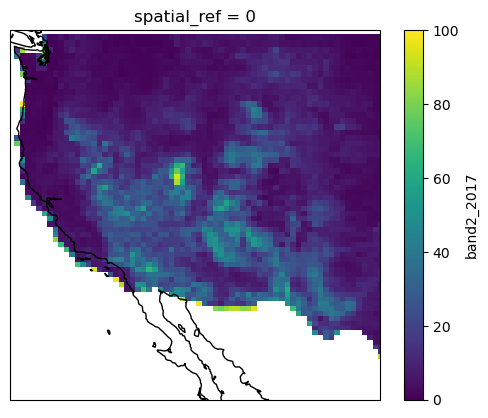

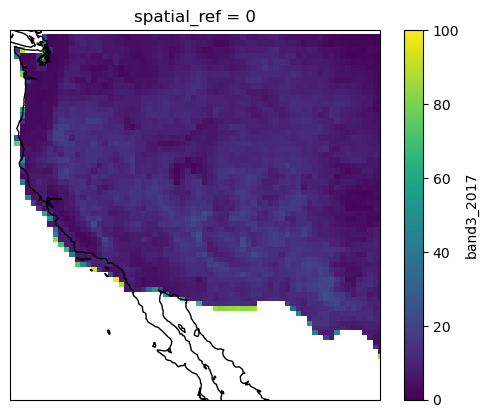

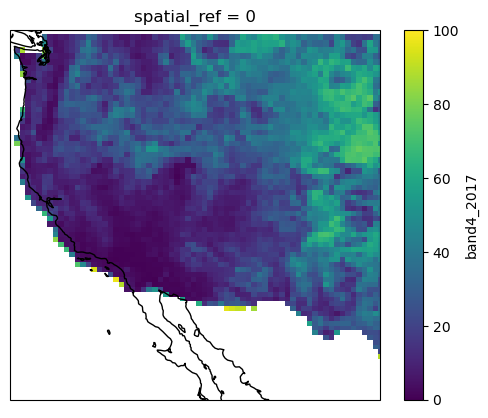

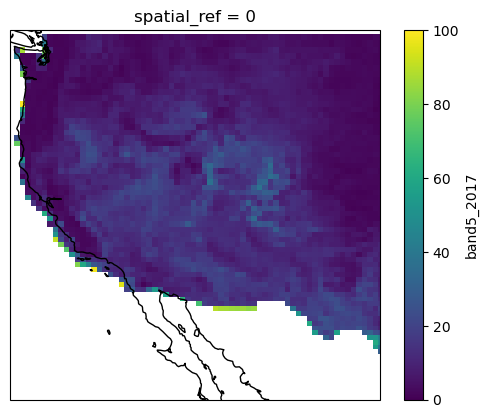

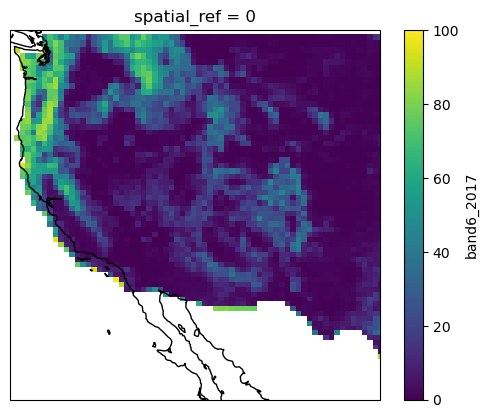

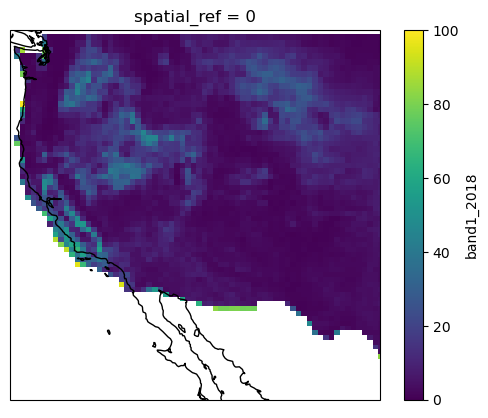

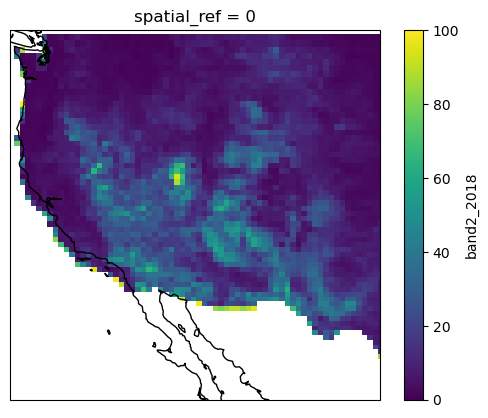

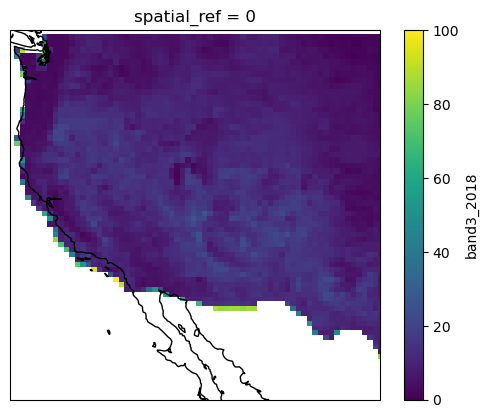

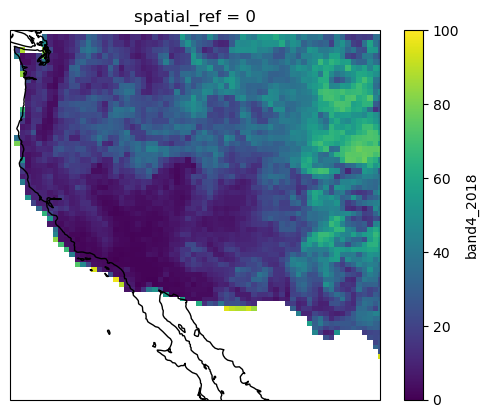

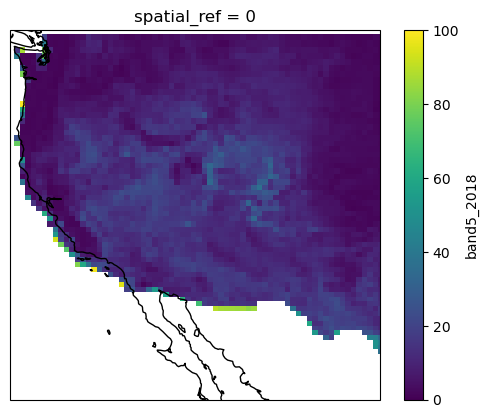

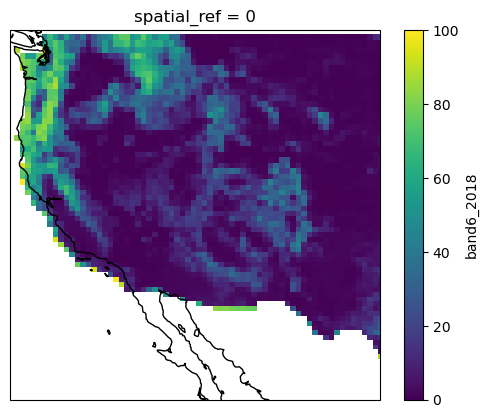

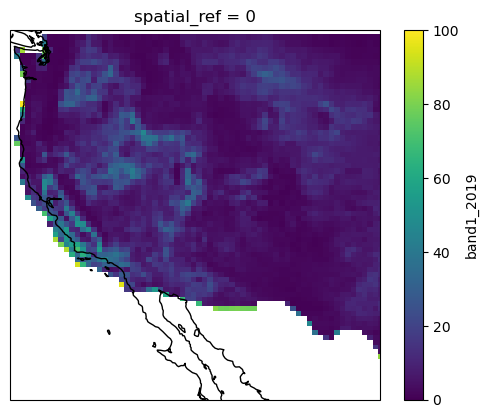

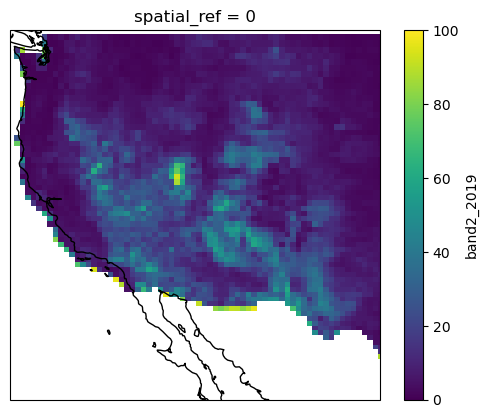

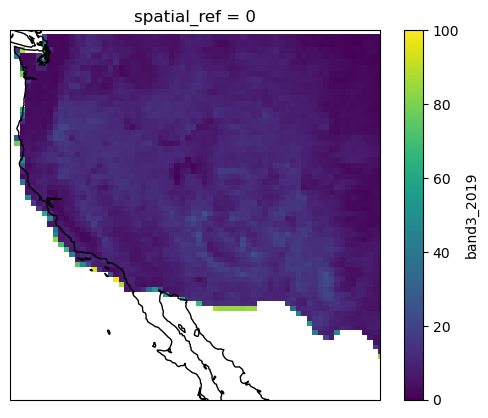

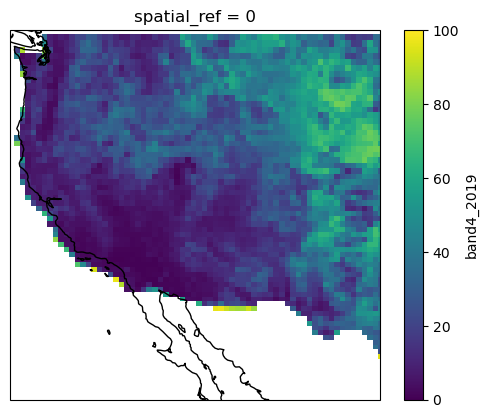

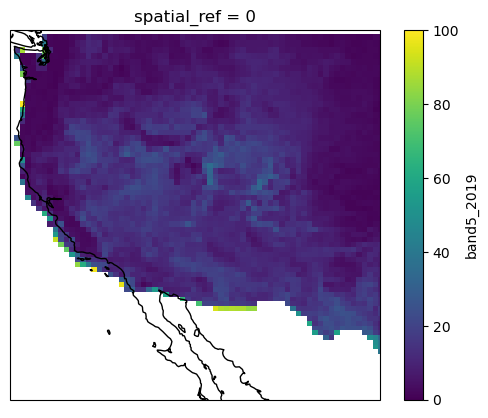

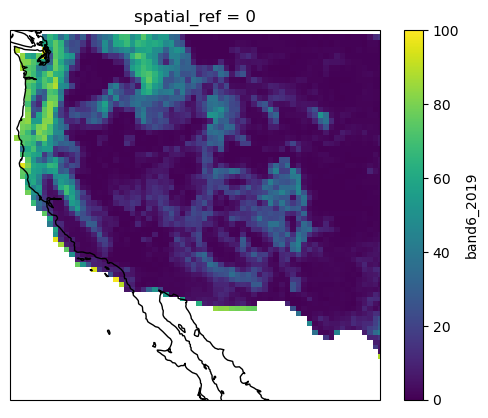

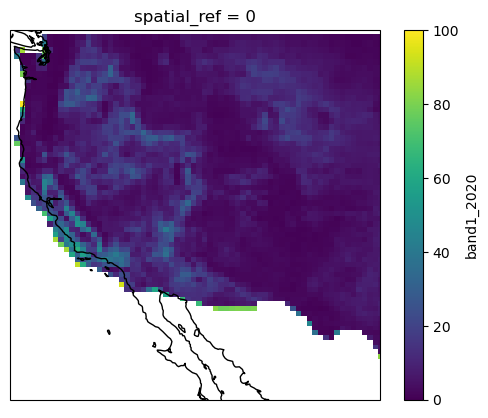

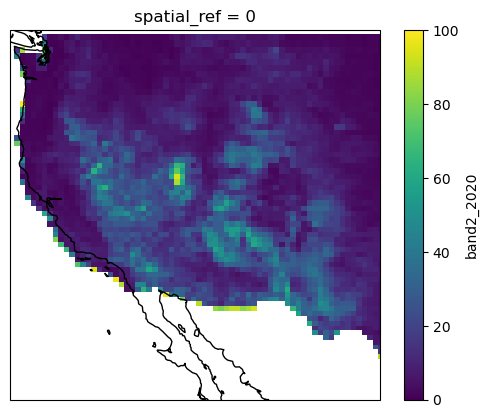

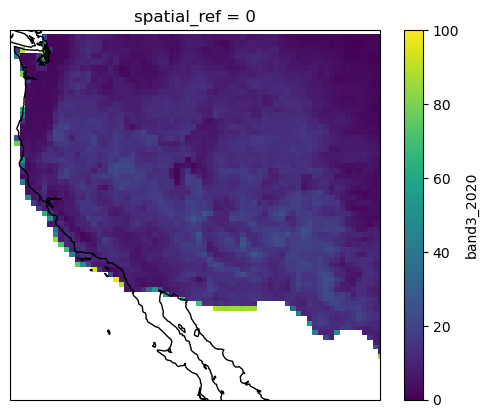

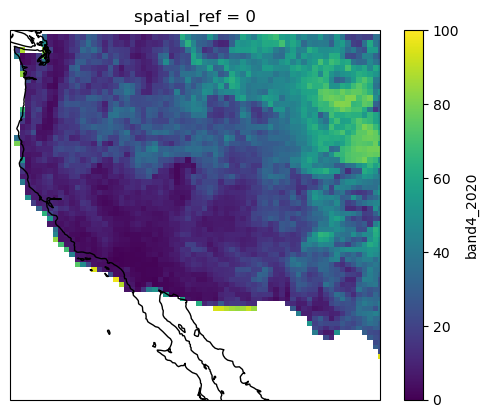

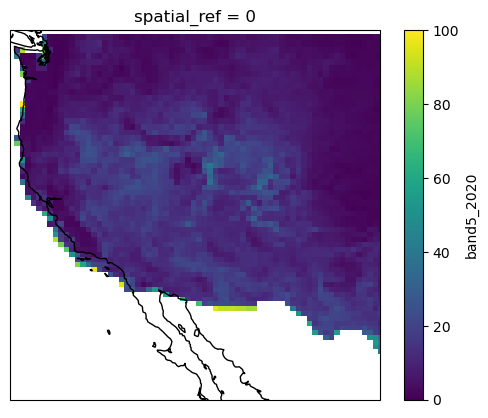

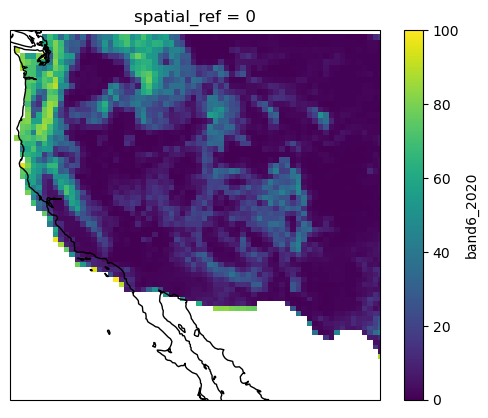

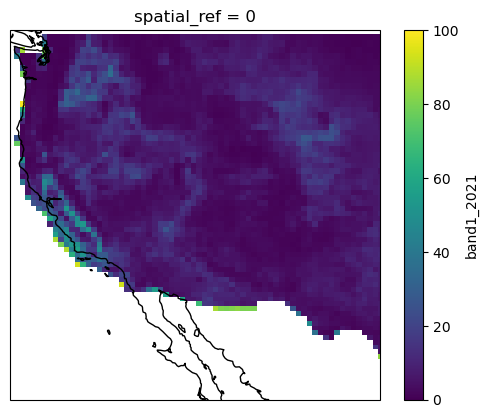

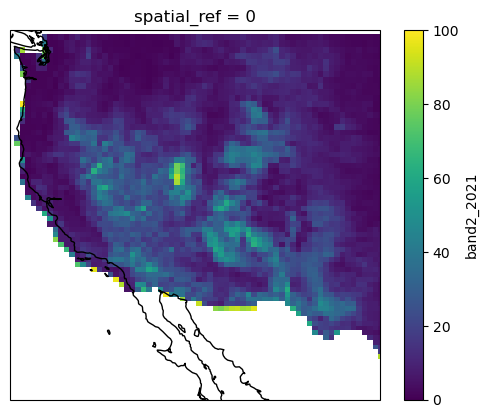

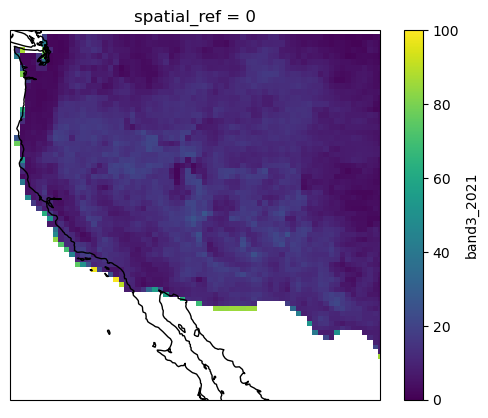

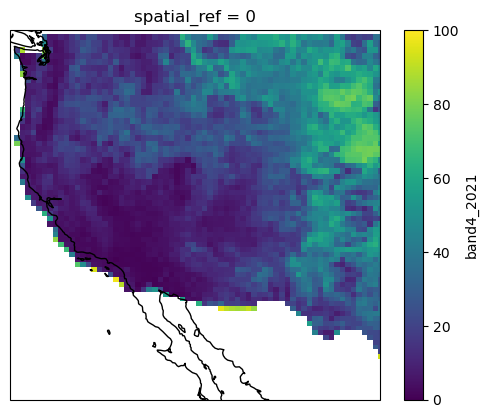

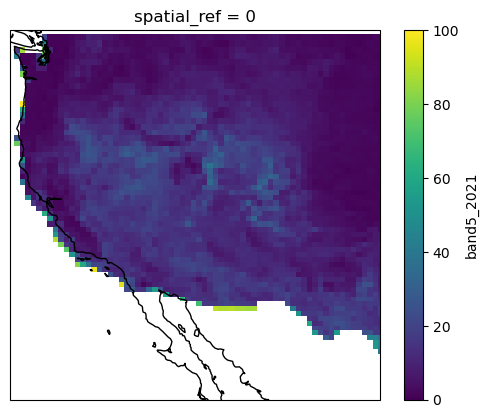

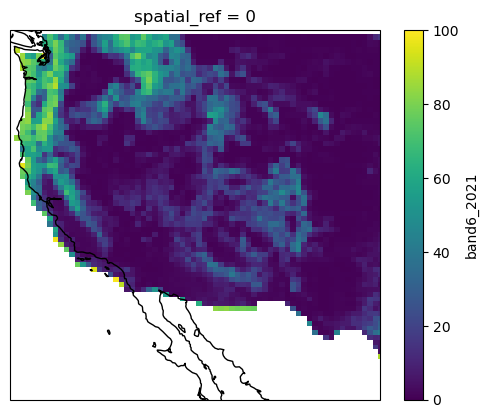

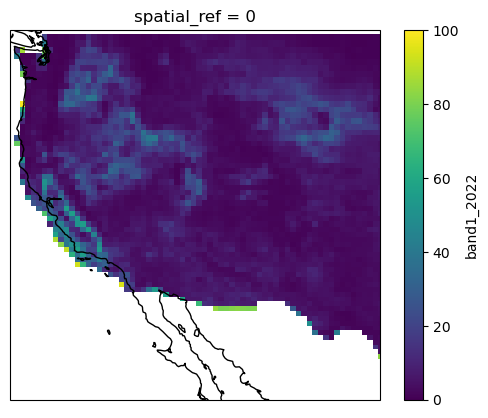

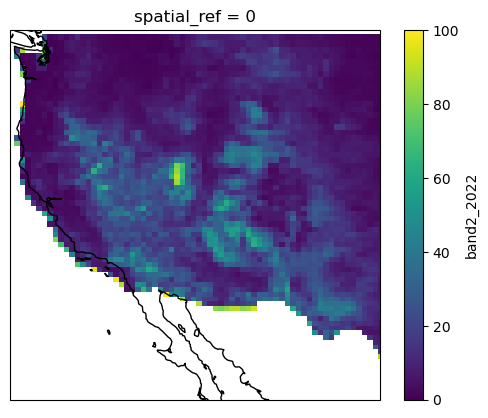

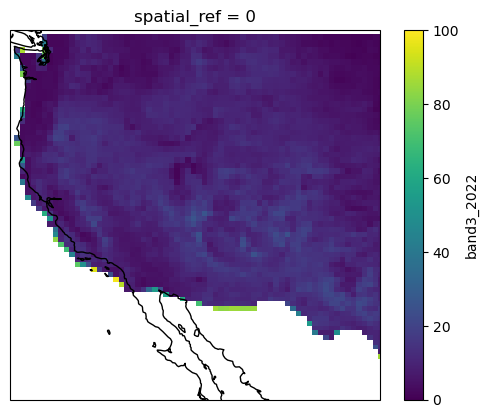

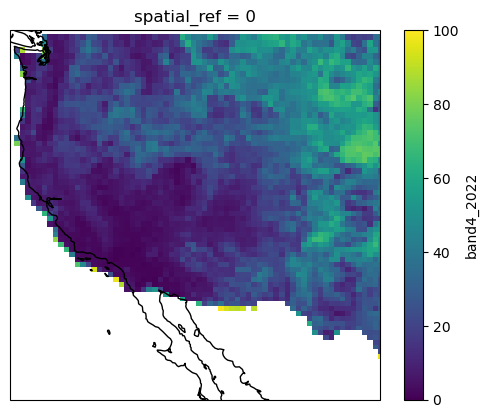

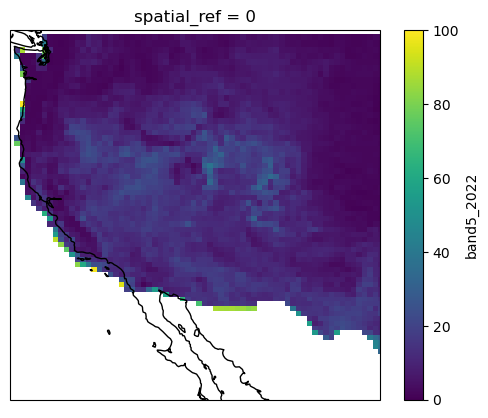

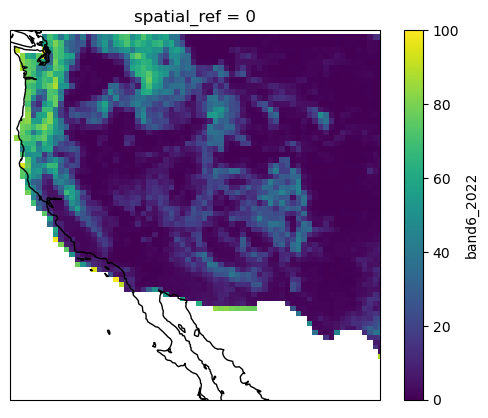

In [4]:
# Define the range of years and band numbers
years = range(2015, 2023)  # 2023 is not included, so it goes up to 2022
band_numbers = range(1, 7)  # 7 is not included, so it goes up to 6

for year in years:
    for band in band_numbers:
        base_dir = os.path.join(data_dir, rangeland_dir)
        file=f"{year}_band{band}.nc"
        _ds = xr.open_dataset(f"{base_dir}/{file}")
        _ds = _ds.rename({'__xarray_dataarray_variable__': 'landcover_fraction'})
        _ds['landcover_fraction'] = _ds['landcover_fraction'].where(_ds['landcover_fraction'] <= 100, np.nan)
        _ds = _ds.rio.write_crs("epsg:4326")
        
        var_name = f"band{band}_{year}"
        ds_SMAPL3_coord_template[var_name] = _ds['landcover_fraction']
        
        fig, ax = plt.subplots(subplot_kw={'projection': projection})
        # conus_extent = [-125, -100, 24.5, 49.5]
        # conus_extent = [-125, -66.5, 24.5, 49.5]
        ds_SMAPL3_coord_template[var_name].plot(ax=ax, transform=projection, vmin=0, vmax=100)
        ax.set_extent(conus_extent, crs=ccrs.PlateCarree())
        ax.coastlines()
        plt.show()


In [5]:
EASE_column_index_xarray = xr.DataArray(EASE_column_index_expanded, dims=('y', 'x'), coords={'y': ds_SMAPL3_coord_template['y'], 'x': ds_SMAPL3_coord_template['x']})
ds_SMAPL3_coord_template['EASE_column_index'] = EASE_column_index_xarray

EASE_row_index_xarray = xr.DataArray(EASE_row_index_expanded, dims=('y', 'x'), coords={'y': ds_SMAPL3_coord_template['y'], 'x': ds_SMAPL3_coord_template['x']})
ds_SMAPL3_coord_template['EASE_row_index'] = EASE_row_index_xarray

In [6]:
list_varnames = []
for year in years:
    for band in band_numbers:
        list_varnames.append(f"band{band}_{year}")
new_variable_names = ['EASE_column_index', 'EASE_row_index'] + list_varnames
df = ds_SMAPL3_coord_template[new_variable_names].to_dataframe()
df.index.names = ['latitude', 'longitude']
df.drop(columns="spatial_ref", inplace=True)
df

EASE_column_index  EASE_row_index  band1_2015  \
latitude   longitude                                                    
 83.631973 -179.813278                  0               0         NaN   
           -179.439835                  1               0         NaN   
           -179.066391                  2               0         NaN   
           -178.692947                  3               0         NaN   
           -178.319504                  4               0         NaN   
...                                   ...             ...         ...   
-83.631973  178.319504                959             405         NaN   
            178.692947                960             405         NaN   
            179.066391                961             405         NaN   
            179.439835                962             405         NaN   
            179.813278                963             405         NaN   

                        band2_2015  band3_2015  band4_2015  band5_2015  \
latitude   longitude                                                     
 83.631973 -179.813278         NaN         NaN         NaN         NaN   
           -179.439835         NaN         NaN         NaN         NaN   
           -179.066391         NaN         NaN         NaN         NaN   
           -178.692947         NaN         NaN         NaN         NaN   
           -178.319504         NaN         NaN         NaN         NaN   
...                            ...         ...         ...         ...   
-83.631973  178.319504         NaN         NaN         NaN         NaN   
            178.692947         NaN         NaN         NaN         NaN   
            179.066391         NaN         NaN         NaN         NaN   
            179.439835         NaN         NaN         NaN         NaN   
            179.813278         NaN         NaN         NaN         NaN   

                        band6_2015  band1_2016  band2_2016  ...  band3_2021  \
latitude   longitude                                        ...               
 83.631973 -179.813278         NaN         NaN         NaN  ...         NaN   
           -179.439835         NaN         NaN         NaN  ...         NaN   
           -179.066391         NaN         NaN         NaN  ...         NaN   
           -178.692947         NaN         NaN         NaN  ...         NaN   
           -178.319504         NaN         NaN         NaN  ...         NaN   
...                            ...         ...         ...  ...         ...   
-83.631973  178.319504         NaN         NaN         NaN  ...         NaN   
            178.692947         NaN         NaN         NaN  ...         NaN   
            179.066391         NaN         NaN         NaN  ...         NaN   
            179.439835         NaN         NaN         NaN  ...         NaN   
            179.813278         NaN         NaN         NaN  ...         NaN   

                        band4_2021  band5_2021  band6_2021  band1_2022  \
latitude   longitude                                                     
 83.631973 -179.813278         NaN         NaN         NaN         NaN   
           -179.439835         NaN         NaN         NaN         NaN   
           -179.066391         NaN         NaN         NaN         NaN   
           -178.692947         NaN         NaN         NaN         NaN   
           -178.319504         NaN         NaN         NaN         NaN   
...                            ...         ...         ...         ...   
-83.631973  178.319504         NaN         NaN         NaN         NaN   
            178.692947         NaN         NaN         NaN         NaN   
            179.066391         NaN         NaN         NaN         NaN   
            179.439835         NaN         NaN         NaN         NaN   
            179.813278         NaN         NaN         NaN         NaN   

                        band2_2022  band3_2022  band4_2022  band5_2022  \
latitude   longitude                          

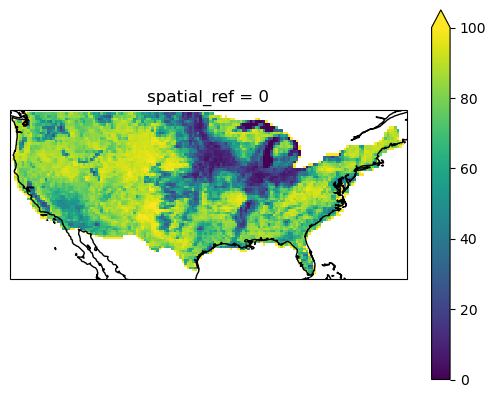

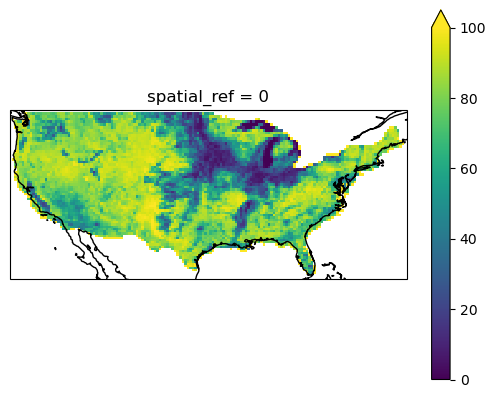

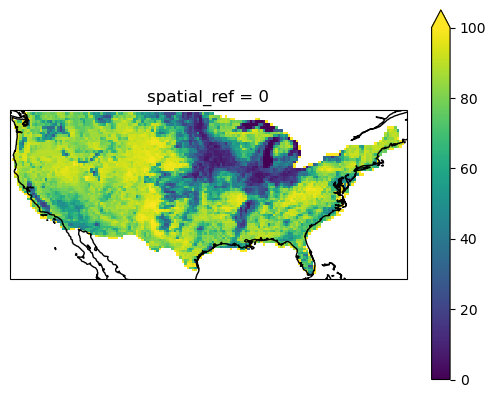

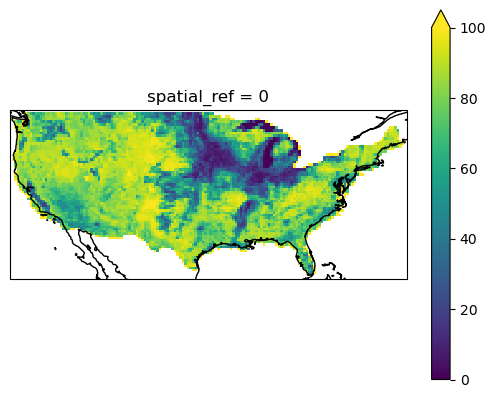

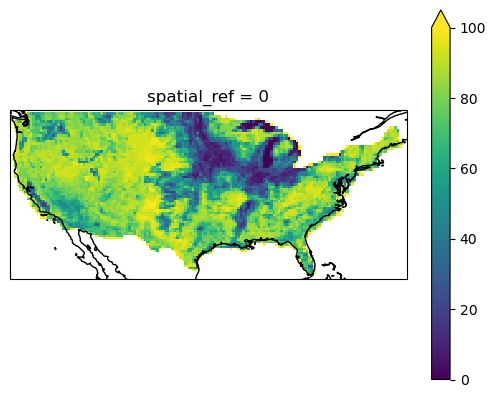

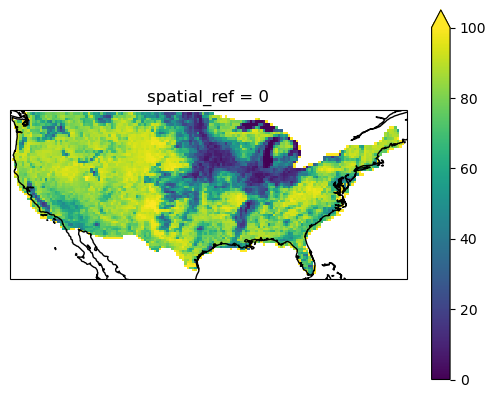

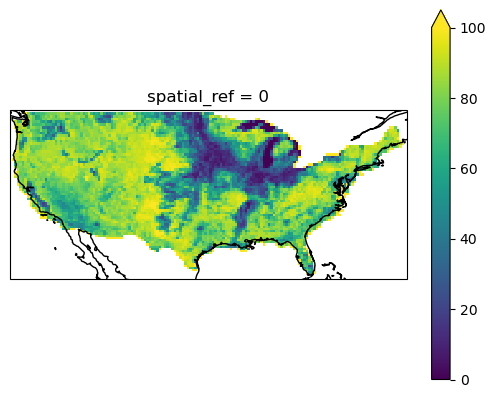

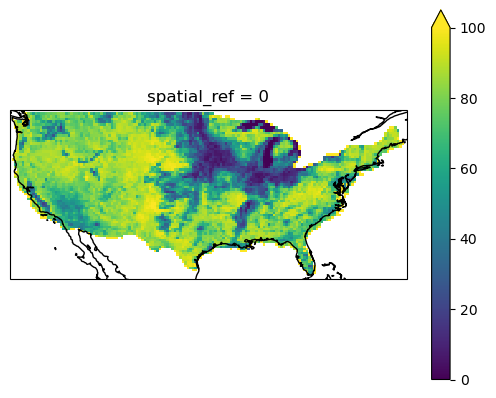

In [7]:
for year in years:
    variable_names_year = [f'band{i}_{year}' for i in range(1, 7)]
    variables_to_sum = [ds_SMAPL3_coord_template[var] for var in variable_names_year if var in ds_SMAPL3_coord_template.data_vars]
    # Calculate the sum of the values for each band in the current year
    sums_ds = sum(variables_to_sum)

    fig, ax = plt.subplots(subplot_kw={'projection': projection})
    # conus_extent = [-125, -100, 24.5, 49.5]
    conus_extent = [-125, -66.5, 24.5, 49.5]
    sums_ds.plot(ax=ax, transform=projection, vmin=0, vmax=100)
    ax.set_extent(conus_extent, crs=ccrs.PlateCarree())
    ax.coastlines()
    plt.show()

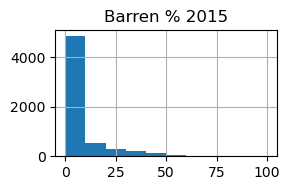

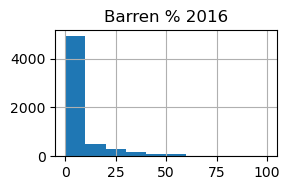

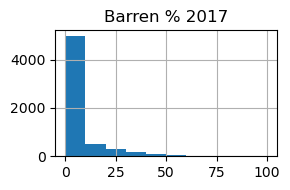

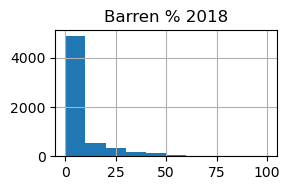

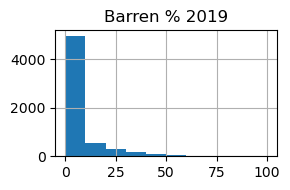

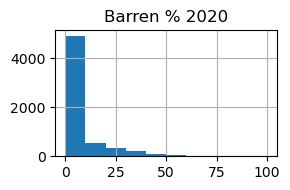

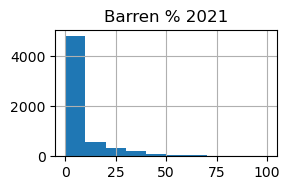

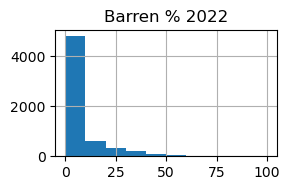

In [8]:
for year in range(2015, 2023):
    # List of column names for the current year
    column_year = f'band2_{year}'  # Fixed variable name for clarity
    
    # Check if the column exists in the DataFrame
    if column_year in df.columns:
        # Create a figure and a single subplot
        fig, ax = plt.subplots(figsize=(3, 2))  # Corrected function call
        
        # Plot histogram for the column of the current year
        df[column_year].hist(bins=10, ax=ax)
        
        # Set title to indicate the year and band
        ax.set_title(f'Barren % {year}')
        
        # Adjust the layout to be tight
        plt.tight_layout()
        
        # Show the plot
        plt.show()

- Woody = tree (6) + shrub (5)
- Herbacious = perrenial (4) & annual (1) grasses
- fractional woody = woody/total veg (barren (2) & litter (3) removed)
    = woody/(woody + herb)
- fractional herb = herb /total veg (barren (2) & litter (3) removed)
    = herb/(woody + herb)
- Remove >20% Barren
- Remove total rangeland cover < 80%

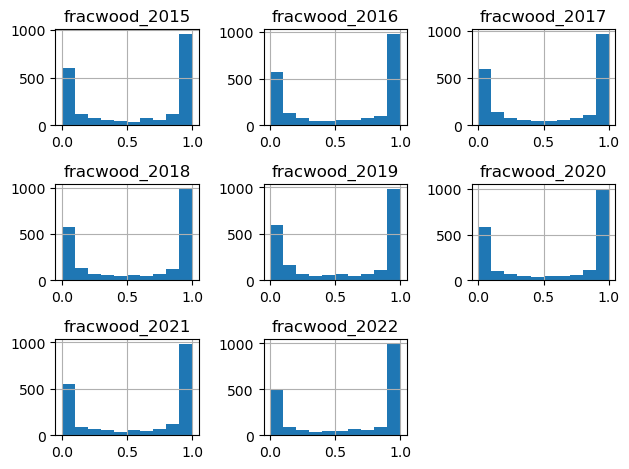

In [19]:
# Initialize a dictionary to hold the sum for each band and year
sums_df = pd.DataFrame(index=df.index)

# Loop through each year from 2015 to 2022
for year in range(2015, 2023):
    # List of column names for the current year

    ## Total percent area
    sum_columns_year  = [f'band{i}_{year}' for i in range(1, 7)]
    # Calculate the sum of the values for each band in the current year
    sums_df[f'sum_{year}'] = df[sum_columns_year].sum(axis=1, skipna=True)


    ## Woody percent area
    woody_columns_year = [f'band{i}_{year}' for i in [5, 6]]
    sums_df[f'woody_{year}'] = df[woody_columns_year].sum(axis=1, skipna=True)

    ## herbacious percent area
    herbacious_columns_year = [f'band{i}_{year}' for i in [1, 4]]
    sums_df[f'herbacious_{year}'] = df[herbacious_columns_year].sum(axis=1, skipna=True)

    ## Barren percent area
    barren_columns_year = [f'band{i}_{year}' for i in [2, 3]]
    sums_df[f'barren_{year}'] = df[barren_columns_year].sum(axis=1, skipna=True)
    sums_df.replace(0, np.nan, inplace=True)


    
    # Create a new column with np.nan values where the condition is True, otherwise keep the original values
    # Use np.nan to replace values where the condition is met

    # sums_df[f'totalveg_{year}'] = sums_df[f'woodyMasked_{year}']  + sums_df[f'herbaciousMasked_{year}'] 

    # Condition for replacement
    # condition = (sums_df[f'sum_{year}'] < 80) | (sums_df[f'barren_{year}'] > 20)
    sums_df[f'totalveg_{year}'] = sums_df[f'woody_{year}']  + sums_df[f'herbacious_{year}'] 
    condition = sums_df[f'totalveg_{year}'] < 80
    sums_df[f'totalveg_{year}'] = sums_df[f'totalveg_{year}'].where(~condition, np.nan)
    sums_df[f'woodyMasked_{year}'] = sums_df[f'woody_{year}'].where(~condition, np.nan)
    sums_df[f'herbaciousMasked_{year}'] = sums_df[f'herbacious_{year}'].where(~condition, np.nan)

    sums_df[f'fracwood_{year}'] =  sums_df[f'woodyMasked_{year}'] / sums_df[f'totalveg_{year}']
    sums_df[f'fracherb_{year}'] =  sums_df[f'herbaciousMasked_{year}'] / sums_df[f'totalveg_{year}']

sums_df = sums_df.join(df)
plot_columns = [f'fracwood_{year}' for year in range(2015, 2023)]

# Display the sum for each band across the years
# Plot histograms for all columns in sums_df
sums_df[plot_columns].hist(bins=10)

# Adjust the layout to be tight
plt.tight_layout()

# Show the plot
plt.show()

In [10]:
# Assuming `data` is your DataFrame with the columns as described

# Melt the DataFrame to go from wide to long format
# Define a dictionary mapping band numbers to their descriptions
band_descriptions = {
    1: "Annual forb and grass",
    2: "Bare ground",
    3: "Litter",
    4: "Perennial forb and grass",
    5: "Shrub",
    6: "Tree"
}

def melt_df(df, original_column_header, new_column_header):
    print(f"Melting {original_column_header}")
    if original_column_header=="band":
        melt_columns = [f'{original_column_header}{i}_{year}' for year in range(2015, 2023) for i in range(1,7)]
    else:
        melt_columns = [f'{original_column_header}_{year}' for year in range(2015, 2023)]
    melt_columns.append('EASE_column_index')
    melt_columns.append('EASE_row_index')
    
    melted_df = df[melt_columns].melt(id_vars=["EASE_column_index","EASE_row_index"], value_name="value")

    if original_column_header=="band":
        melted_df["band"] = melted_df["variable"].apply(lambda x: int(x.split('_')[0].replace(original_column_header, "")))
    melted_df["year"] = melted_df["variable"].apply(lambda x: x.split('_')[-1])
    if original_column_header=="band":
        melted_df["functional_group"] = melted_df["band"].map(band_descriptions)

    melted_df.rename(columns={"value": new_column_header}, inplace=True)
    melted_df.drop(columns="variable",inplace=True)
    print(melted_df.head())
    return melted_df

In [11]:
melted_df_rawdata = melt_df(df, "band", "landcover_percent")
out_df = pd.merge(df[["EASE_column_index", "EASE_row_index"]], melted_df_rawdata, on=["EASE_column_index", "EASE_row_index"], how='outer')
filename = r"/home/raraki/waves/projects/smap-drydown/data/datarods/anc_info_rangeland.csv"
out_df.to_csv(filename)

Melting band
   EASE_column_index  EASE_row_index  landcover_percent  band  year  \
0                  0               0                NaN     1  2015   
1                  1               0                NaN     1  2015   
2                  2               0                NaN     1  2015   
3                  3               0                NaN     1  2015   
4                  4               0                NaN     1  2015   

        functional_group  
0  Annual forb and grass  
1  Annual forb and grass  
2  Annual forb and grass  
3  Annual forb and grass  
4  Annual forb and grass  


In [16]:
melted_df_woody = melt_df(sums_df, "fracwood", "fractional_wood")
melted_df_herb = melt_df(sums_df, "fracherb", "fractional_herb")
melted_df_totveg = melt_df(sums_df, "totalveg", "vegetation_percent")
melted_df_barren = melt_df(sums_df, "barren", "barren_percent")
melted_df_totalrangeland = melt_df(sums_df, "sum", "totalrangeland_percent")

Melting fracwood
   EASE_column_index  EASE_row_index  fractional_wood  year
0                  0               0              NaN  2015
1                  1               0              NaN  2015
2                  2               0              NaN  2015
3                  3               0              NaN  2015
4                  4               0              NaN  2015
Melting fracherb
   EASE_column_index  EASE_row_index  fractional_herb  year
0                  0               0              NaN  2015
1                  1               0              NaN  2015
2                  2               0              NaN  2015
3                  3               0              NaN  2015
4                  4               0              NaN  2015
Melting totalveg
   EASE_column_index  EASE_row_index  vegetation_percent  year
0                  0               0                 NaN  2015
1                  1               0                 NaN  2015
2                  2               0    

In [17]:
from functools import reduce

# List of DataFrames to be joined
dfs = [melted_df_woody, melted_df_herb, melted_df_totveg, melted_df_barren, melted_df_totalrangeland]

# Use reduce to iteratively merge all DataFrames on 'EASE_column_index' and 'EASE_row_index'
merged_out_df = reduce(lambda left, right: pd.merge(left, right, on=['EASE_column_index', 'EASE_row_index', 'year'], how='inner'), dfs)
merged_out_df.head()
# Now, merged_df contains all the joined data


EASE_column_index  EASE_row_index  fractional_wood  year  fractional_herb  \
0                  0               0              NaN  2015              NaN   
1                  1               0              NaN  2015              NaN   
2                  2               0              NaN  2015              NaN   
3                  3               0              NaN  2015              NaN   
4                  4               0              NaN  2015              NaN   

   vegetation_percent  barren_percent  totalrangeland_percent  
0                 NaN             NaN                     NaN  
1                 NaN             NaN                     NaN  
2                 NaN             NaN                     NaN  
3                 NaN             NaN                     NaN  
4                 NaN             NaN                     NaN

In [18]:
# out_df = pd.merge(df[["EASE_column_index", "EASE_row_index"]], merged_out_df, on=["EASE_column_index", "EASE_row_index"], how='outer')
filename = r"/home/raraki/waves/projects/smap-drydown/data/datarods/anc_info_rangeland_processed.csv"
merged_out_df.to_csv(filename)

# Output

In [19]:
filename = r"/home/raraki/waves/projects/smap-drydown/data/datarods/anc_info_rangeland.csv"
out_df.to_csv(filename)

In [39]:
import pandas as pd
data = pd.read_csv(filename)
data.head()

latitude  longitude  EASE_column_index  EASE_row_index  band1_2015  \
0  83.63197 -179.81328                  0               0         NaN   
1  83.63197 -179.43983                  1               0         NaN   
2  83.63197 -179.06639                  2               0         NaN   
3  83.63197 -178.69295                  3               0         NaN   
4  83.63197 -178.31950                  4               0         NaN   

   band2_2015  band3_2015  band4_2015  band5_2015  band6_2015  ...  \
0         NaN         NaN         NaN         NaN         NaN  ...   
1         NaN         NaN         NaN         NaN         NaN  ...   
2         NaN         NaN         NaN         NaN         NaN  ...   
3         NaN         NaN         NaN         NaN         NaN  ...   
4         NaN         NaN         NaN         NaN         NaN  ...   

   band4_2021  band5_2021  band6_2021  band1_2022  band2_2022  band3_2022  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   band4_2022  band5_2022  band6_2022  spatial_ref  
0         NaN         NaN         NaN            0  
1         NaN         NaN         NaN            0  
2         NaN         NaN         NaN            0  
3         NaN         NaN         NaN            0  
4         NaN         NaN         NaN            0  

[5 rows x 53 columns]

/tmp/ipykernel_1254272/3454353063.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(5,4))


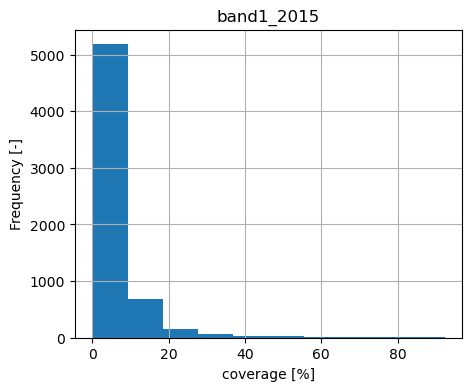

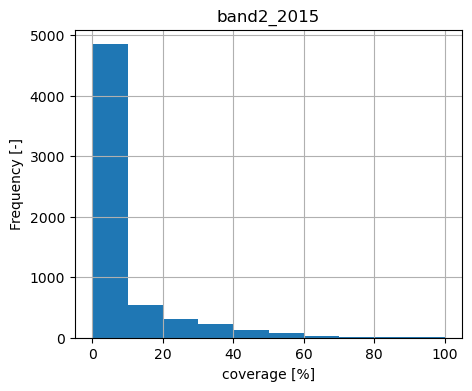

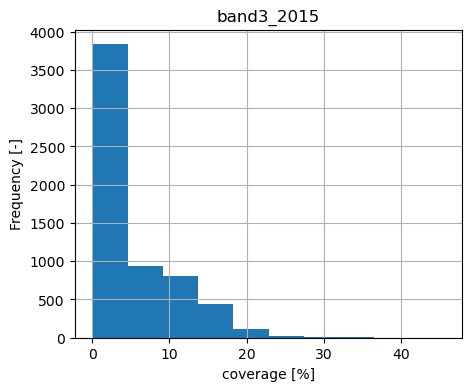

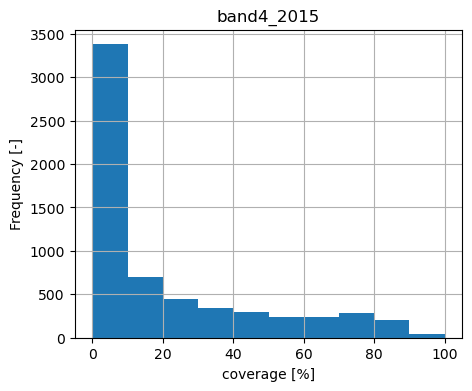

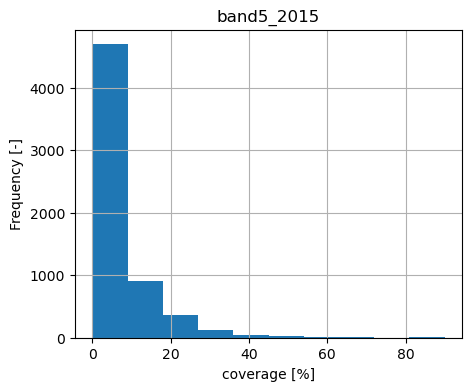

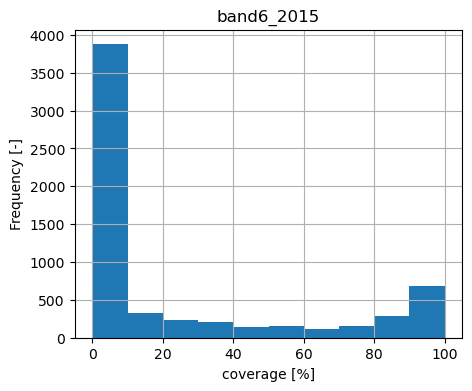

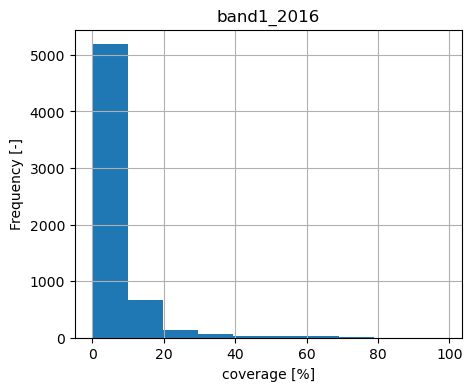

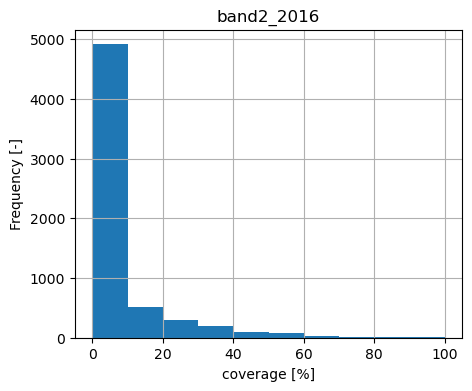

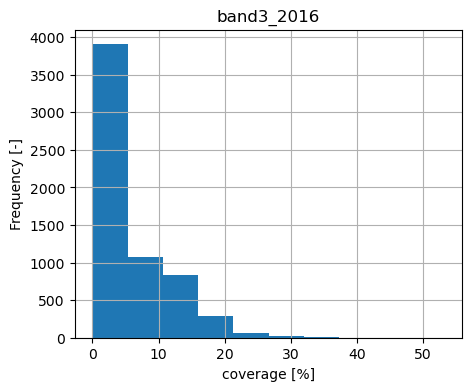

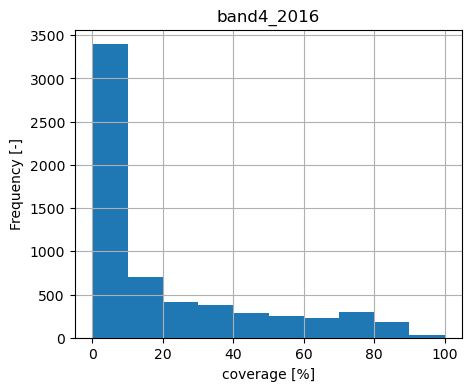

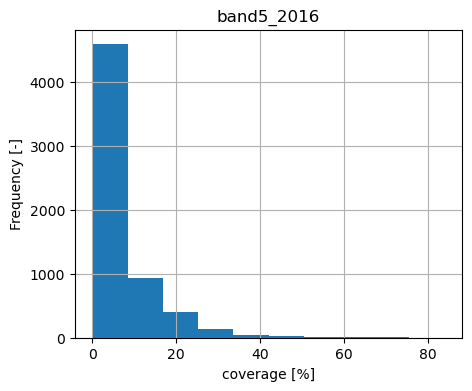

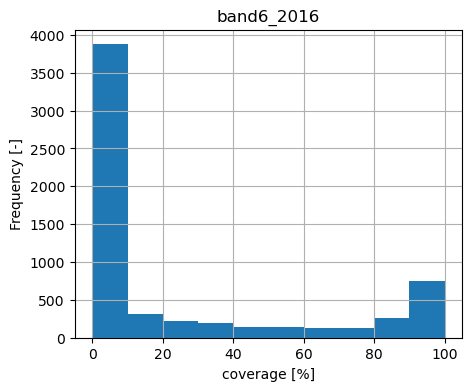

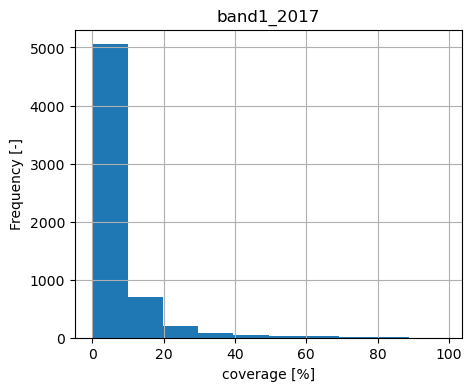

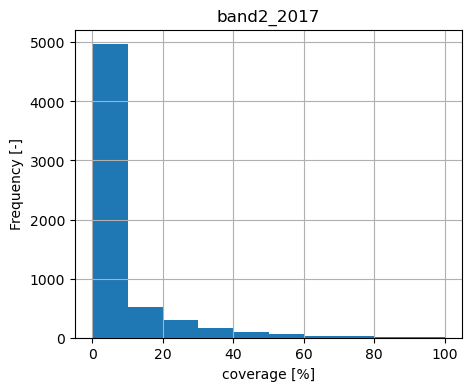

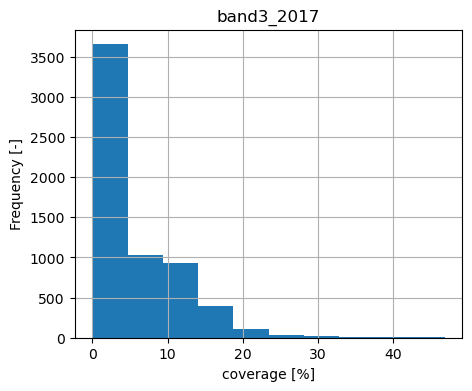

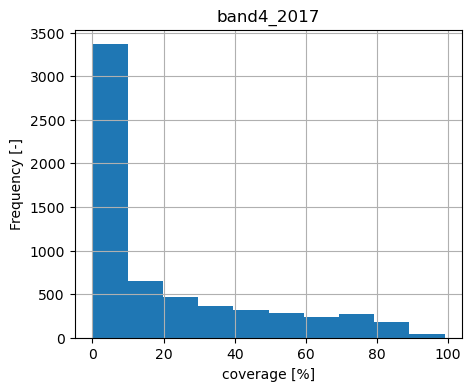

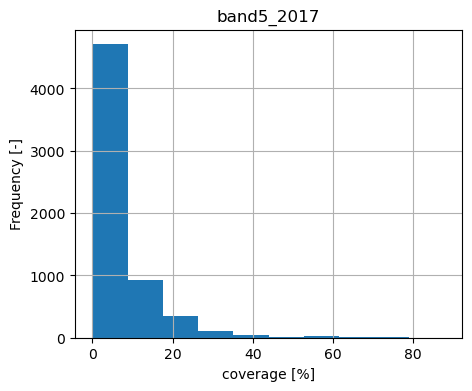

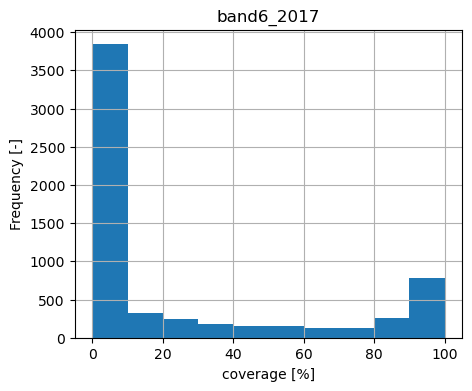

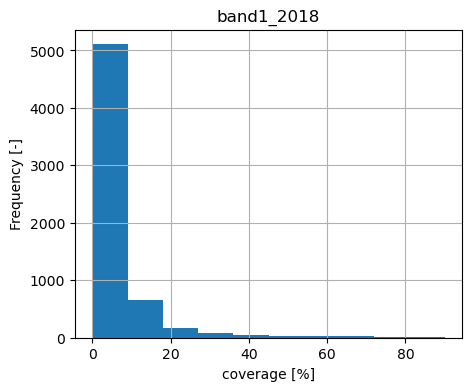

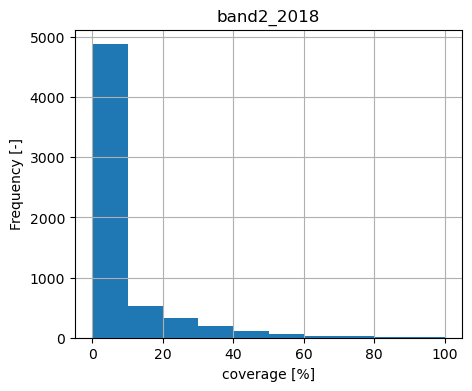

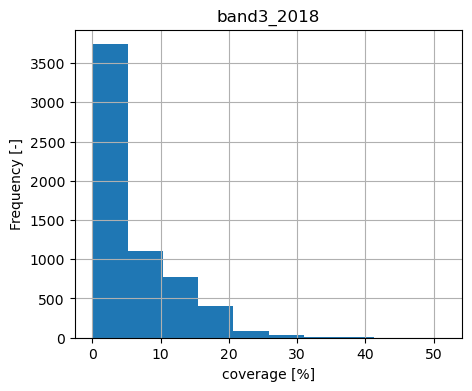

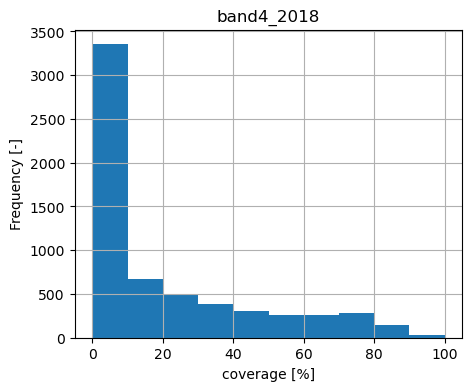

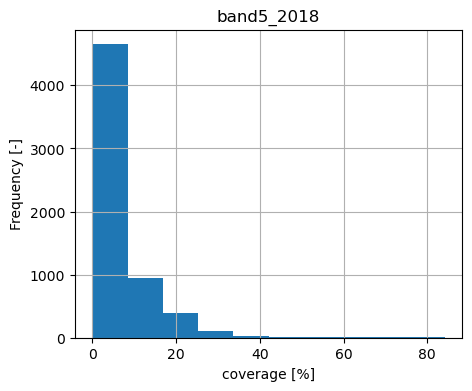

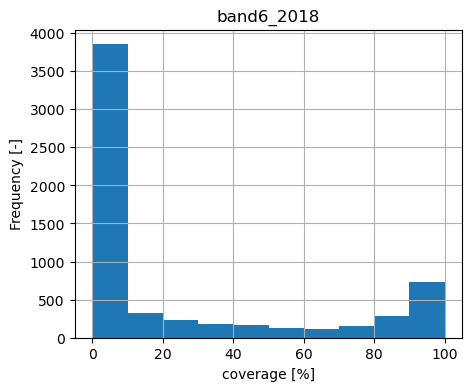

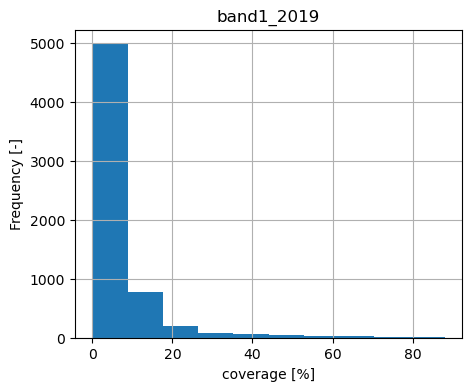

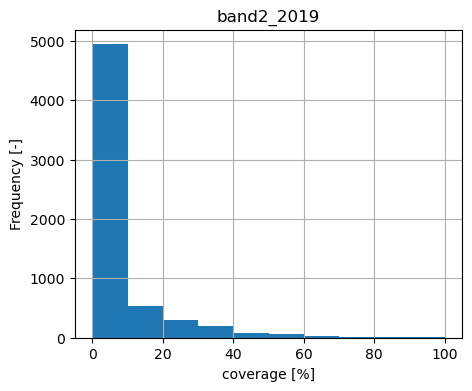

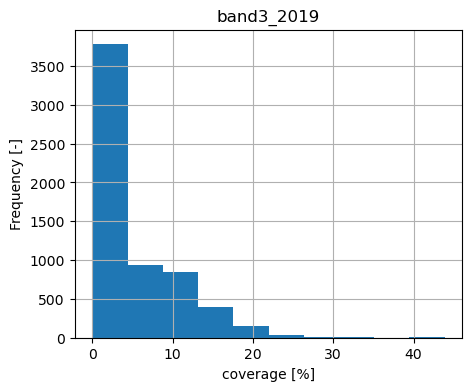

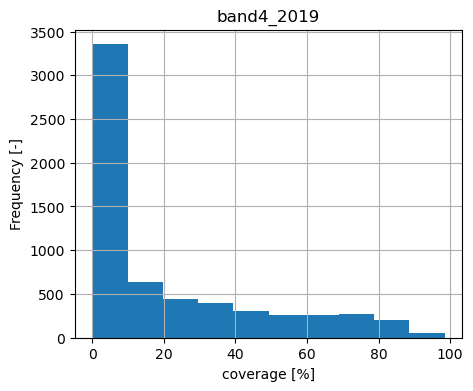

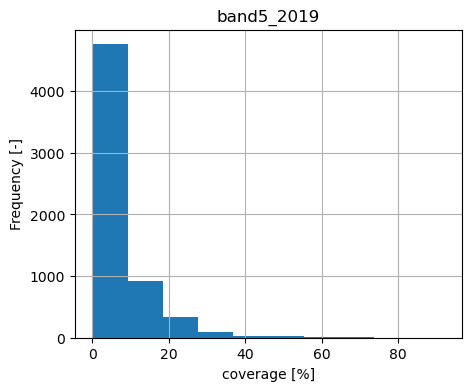

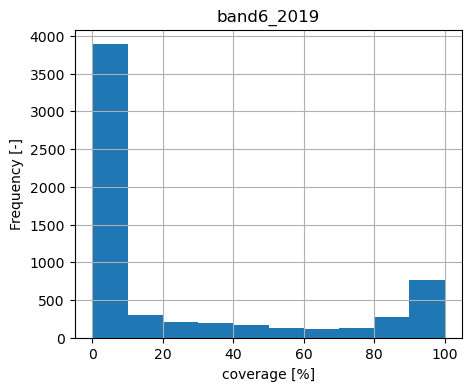

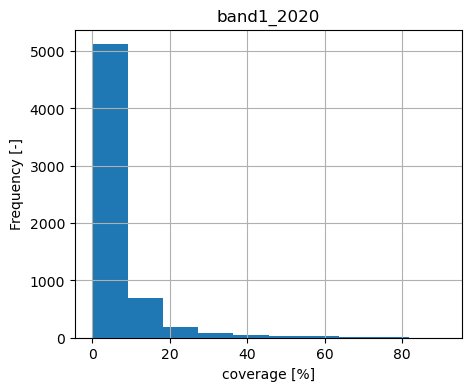

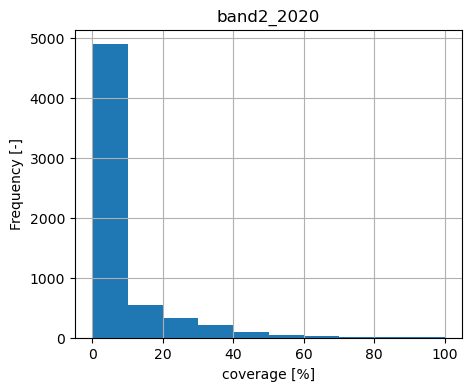

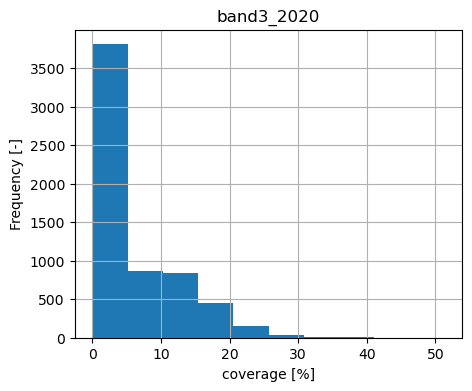

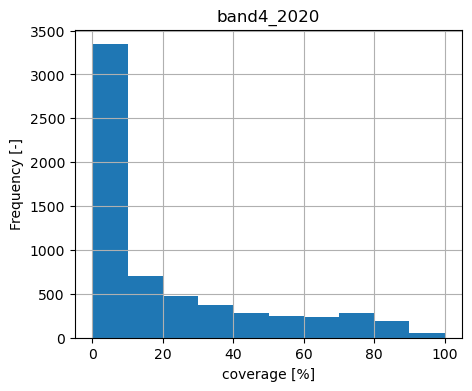

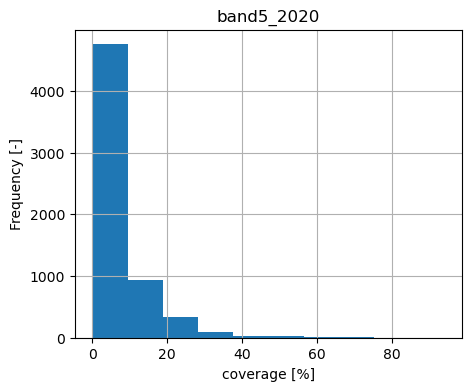

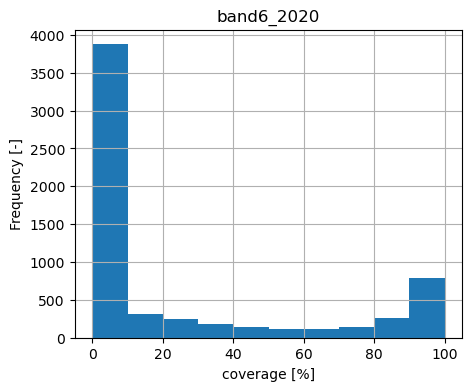

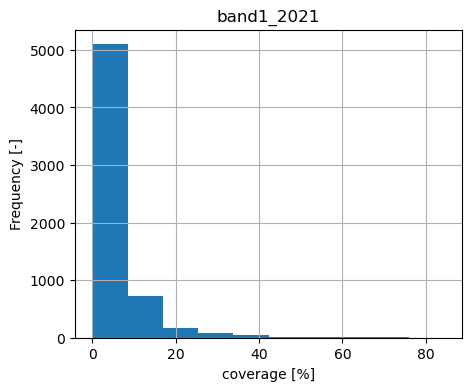

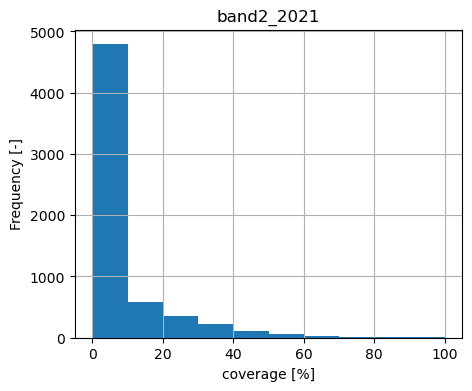

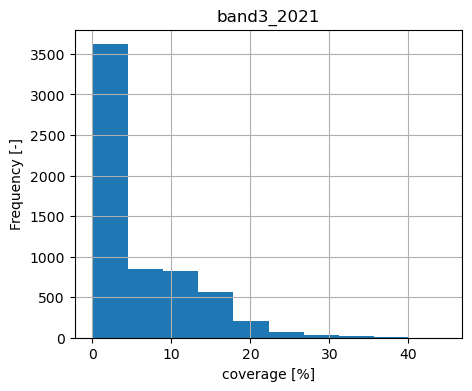

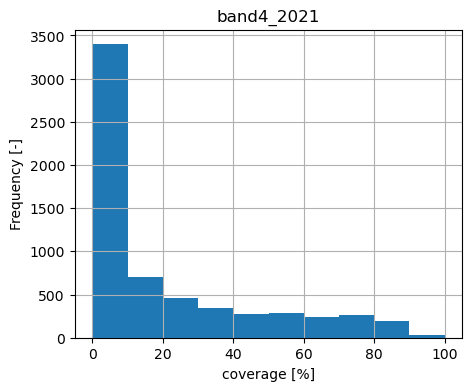

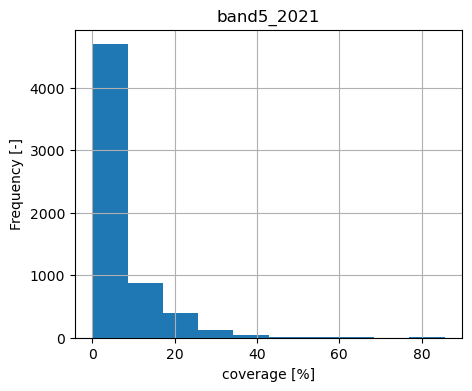

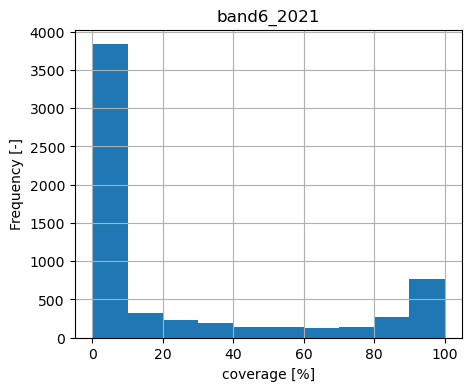

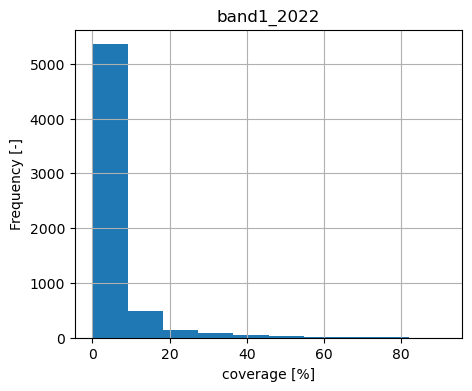

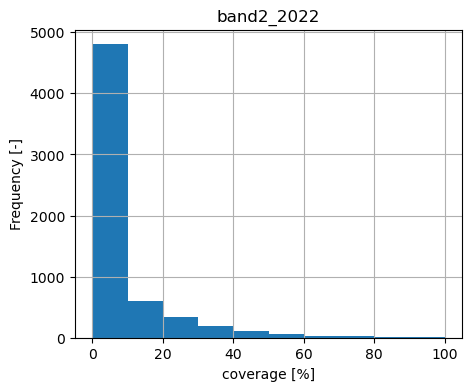

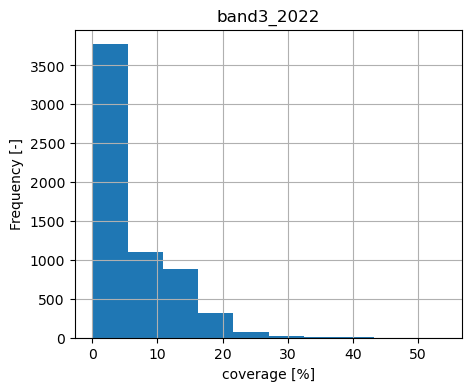

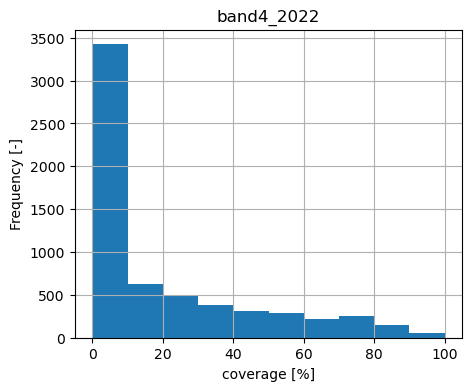

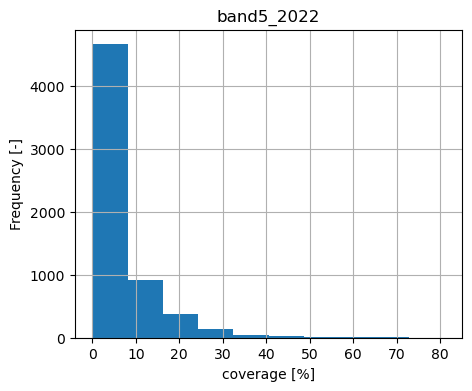

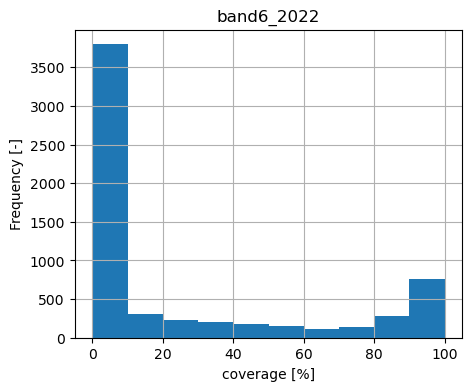

In [52]:
for year in years:
    for band in band_numbers:
        fig, ax = plt.subplots(figsize=(5,4))
        varname = f'band{band}_{year}'
        data[varname].hist(ax=ax)
        ax.set_title(varname)
        ax.set_xlabel('coverage [%]')
        ax.set_ylabel('Frequency [-]')